## Multiclass Classification: Wine Dataset
https://archive.ics.uci.edu/ml/datasets/wine

** Dataset Information: **

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines

** Attribute Information: (12 features and 1 class)**

Class: class 1 (59), class 2 (71), class 3 (48)

1. Alcohol (class)
2. Malic acid 
3. Ash 
4. Alcalinity of ash 
5. Magnesium 
6. Total phenols 
7. Flavanoids 
8. Nonflavanoid phenols 
9. Proanthocyanins 
10. Color intensity 
11. Hue 
12. OD280/OD315 of diluted wines 
13. Proline 

** Objective of this project **

Using chemical analysis (features) determine the origin of wines (class, 1-3)

## Data

In [1]:
import findspark
findspark.init('/home/danny/spark-2.2.1-bin-hadoop2.7')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('wine').getOrCreate()

In [2]:
# Load Data
df = spark.read.csv('Wine_data.csv',inferSchema=True,header=True)
# Inspect Data
df.printSchema()

root
 |-- Class: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- Malic_Acid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Ash_Alcanity: double (nullable = true)
 |-- Magnesium: integer (nullable = true)
 |-- Total_Phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- Nonflavanoid_Phenols: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- Color_Intensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- OD280: double (nullable = true)
 |-- Proline: integer (nullable = true)



In [3]:
df = df.withColumnRenamed('Class','label')
df.show(5)

+-----+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|label|Alcohol|Malic_Acid| Ash|Ash_Alcanity|Magnesium|Total_Phenols|Flavanoids|Nonflavanoid_Phenols|Proanthocyanins|Color_Intensity| Hue|OD280|Proline|
+-----+-------+----------+----+------------+---------+-------------+----------+--------------------+---------------+---------------+----+-----+-------+
|    1|  14.23|      1.71|2.43|        15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04| 3.92|   1065|
|    1|   13.2|      1.78|2.14|        11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|  3.4|   1050|
|    1|  13.16|      2.36|2.67|        18.6|      101|          2.8|      3.24|                 0.3|           2.81|           5.68|1.03| 3.17|   1185|
|    1|  14.37|      1.95| 2.5|        16.8|      113|         3.85|      3.49|         

In [4]:
df.head()

Row(label=1, Alcohol=14.23, Malic_Acid=1.71, Ash=2.43, Ash_Alcanity=15.6, Magnesium=127, Total_Phenols=2.8, Flavanoids=3.06, Nonflavanoid_Phenols=0.28, Proanthocyanins=2.29, Color_Intensity=5.64, Hue=1.04, OD280=3.92, Proline=1065)

In [5]:
df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|summary|             label|           Alcohol|        Malic_Acid|               Ash|     Ash_Alcanity|         Magnesium|     Total_Phenols|        Flavanoids|Nonflavanoid_Phenols|   Proanthocyanins|  Color_Intensity|                Hue|             OD280|          Proline|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+------------------+-----------------+
|  count|               178|               178|               178|               178|              178|               178|               178|               178|            

## Data preprocessing

In [6]:
from pyspark.ml.feature import StringIndexer,VectorAssembler,OneHotEncoder

** Split Features & Class (or target) **

In [7]:
df.columns

['label',
 'Alcohol',
 'Malic_Acid',
 'Ash',
 'Ash_Alcanity',
 'Magnesium',
 'Total_Phenols',
 'Flavanoids',
 'Nonflavanoid_Phenols',
 'Proanthocyanins',
 'Color_Intensity',
 'Hue',
 'OD280',
 'Proline']

In [8]:
# combine features into a single column
assembler = VectorAssembler(inputCols=df.columns[1:],outputCol='features')
output = assembler.transform(df)
#output.show(5)

# features and target
final_data = output.select('features','label')
final_data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[14.23,1.71,2.43,...|    1|
|[13.2,1.78,2.14,1...|    1|
|[13.16,2.36,2.67,...|    1|
|[14.37,1.95,2.5,1...|    1|
|[13.24,2.59,2.87,...|    1|
+--------------------+-----+
only showing top 5 rows



** Split Train Test sets **

In [9]:
seed = 101 #for reproducibility
train_data,test_data = final_data.randomSplit([0.7,0.3],seed=seed)
train_data.describe().show()
test_data.describe().show()

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|               129|
|   mean|2.0155038759689923|
| stddev|0.7703945430349207|
|    min|                 1|
|    max|                 3|
+-------+------------------+

+-------+------------------+
|summary|             label|
+-------+------------------+
|  count|                49|
|   mean|1.7346938775510203|
| stddev|0.7576144084141581|
|    min|                 1|
|    max|                 3|
+-------+------------------+



## Baseline Model

In [10]:
from pyspark.ml.classification import (LogisticRegression,DecisionTreeClassifier,
                                       RandomForestClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#### Train Models

In [11]:
# Initialize multiple models
lrc = LogisticRegression()
dtc = DecisionTreeClassifier(seed=seed)
rfc = RandomForestClassifier(seed=seed)

# Train the models 
lrc_model = lrc.fit(train_data)
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)

#### Evaluate Models

In [12]:
# Make predictions
lrc_predictions = lrc_model.transform(test_data)
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)

In [13]:
# Evaluate the models
acc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
print('\t\t\tAccuracy')
print('Logistic Regression:\t{:.3f}'.format(acc_eval.evaluate(lrc_predictions)))
print('Decision Tree:\t\t{:.3f}'.format(acc_eval.evaluate(dtc_predictions)))
print('Random Forest:\t\t{:.3f}'.format(acc_eval.evaluate(rfc_predictions)))

			Accuracy
Logistic Regression:	0.939
Decision Tree:		0.918
Random Forest:		0.980


## Parameter tuning

#### Grid Search

In [14]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# randomforest
classifier = RandomForestClassifier(seed=seed)
# grid params
paramGrid = ParamGridBuilder() \
    .addGrid(classifier.numTrees, [20,50,100,200]) \
    .build()
# cross validation
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=acc_eval,
                          numFolds=3, 
                          seed=seed)
cvModel = crossval.fit(train_data)
# results
print(cvModel.avgMetrics)
print(cvModel.bestModel) 

[0.9753246753246754, 0.9924242424242424, 0.9924242424242424, 0.9857575757575756]
RandomForestClassificationModel (uid=RandomForestClassifier_4884826646019dc8defb) with 50 trees


#### Evaluate the best model

In [15]:
# make predictions
predictions = cvModel.transform(test_data)
# calculate auc
print('\t\t\tAccuracy')
print('Random Forest:\t{:.3f}'.format(acc_eval.evaluate(predictions)))

			Accuracy
Random Forest:	0.980


## Final Model

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,classification_report

In [17]:
# Train the model
classifier = RandomForestClassifier(numTrees=50)
final_model = classifier.fit(train_data)
# make predictions
predictions = final_model.transform(test_data)
predictions.show(10)

+--------------------+-----+-------------------+--------------------+----------+
|            features|label|      rawPrediction|         probability|prediction|
+--------------------+-----+-------------------+--------------------+----------+
|[11.62,1.99,2.28,...|    2| [0.0,1.1,48.9,0.0]|[0.0,0.0220000000...|       2.0|
|[11.65,1.67,2.62,...|    2| [0.0,0.0,50.0,0.0]|   [0.0,0.0,1.0,0.0]|       2.0|
|[11.66,1.88,1.92,...|    2| [0.0,0.0,49.0,1.0]| [0.0,0.0,0.98,0.02]|       2.0|
|[11.81,2.12,2.74,...|    2| [0.0,3.1,39.9,7.0]|[0.0,0.062,0.7979...|       2.0|
|[11.84,2.89,2.23,...|    2| [0.0,1.0,46.0,3.0]|[0.0,0.02,0.92,0.06]|       2.0|
|[11.96,1.09,2.3,2...|    2|[0.0,13.1,36.9,0.0]|[0.0,0.262,0.738,...|       2.0|
|[12.0,0.92,2.0,19...|    2| [0.0,0.0,50.0,0.0]|   [0.0,0.0,1.0,0.0]|       2.0|
|[12.0,3.43,2.0,19...|    2| [0.0,0.0,50.0,0.0]|   [0.0,0.0,1.0,0.0]|       2.0|
|[12.21,1.19,1.75,...|    2| [0.0,2.1,46.9,1.0]|[0.0,0.042,0.938,...|       2.0|
|[12.25,1.73,2.12,...|    2|

Accuracy:	100.0%


             precision    recall  f1-score   support

          1       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        18
          3       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        49



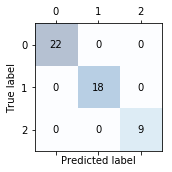

In [18]:
# Evaluate the model
df_pred = predictions.toPandas()
print('Accuracy:\t{:0.1f}%'.format(acc_eval.evaluate(predictions)*100))

#classification report
print('\n')
print(classification_report(df_pred['label'],df_pred['prediction']))

#confusion matrix
confmat = confusion_matrix(df_pred['label'],df_pred['prediction'])

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

In [19]:
spark.stop()